In [1]:
import gizeh
import numpy as np

In [2]:
def get_neighbour_influence(angle, influence):
    """Get a coefficient of influence in neighbour cell
    
    Parameters
    ----------
    angle : float
        Angle between flow direction and the given neighbour
        
    influence : float
        
    Returns
    -------
    influence : float
        Number representing influence of a stem cell in the neighbour cell. In this model we assume that it changes
        linearly with the change of the angle. It equals 0 in the opposite direction from the flow 
        and influence/2 in the direction of the flow
    """
    angle = angle % (2*np.pi)
    return influence * abs(np.pi - angle) / (2*np.pi)

In [3]:
def in_same_semicircle(angle_1, angle_2):
    angle_1 %= 2*np.pi
    angle_2 %= 2*np.pi
    
    if (np.pi/2 <= angle_1 < 1.5*np.pi):
        return (angle_1 - np.pi/2) < angle_2 <= (angle_1 + np.pi/2)
    
    elif angle_1 < np.pi/2:
        return (0 <= angle_2 <= angle_1 + np.pi/2) or ( ( (angle_1 - np.pi/2) % (2*np.pi) ) < angle_2 <= 2*np.pi)
    
    elif angle_1 >= 1.5*np.pi:
        return (angle_1 - np.pi/2 < angle_2 <= 2*np.pi) or (0 <= angle_2 < ( (angle_1 + np.pi/2) % (2*np.pi) ) )

In [4]:
class Cell:
    MAX_CONCENTRATION = 1024
    
    def __init__(self, x, y, radius, is_stem=False, stem_angle=None):
        self.x = x
        self.y = y
        self.radius = radius
        self.is_stem = is_stem
        self.neighbours = {}
        self.checked = False
        self.gradient = {'x': 0,
                         'y': 0}
        
        self.stem_angle = stem_angle if self.is_stem else None
        self.concentration = Cell.MAX_CONCENTRATION if self.is_stem else 0
            
    def __repr__(self):
        return '(x: {x}, y: {y}), {c} {stem}, gradient: ({g_x}, {g_y})'.format(
                 x = self.x,
                 y = self.y,
                 c = self.concentration,
                 stem = '*' if self.is_stem else '',
                 g_x = round(self.gradient['x'], 2) if self.gradient['x'] is not None else 'None',
                 g_y = round(self.gradient['y'], 2) if self.gradient['y'] is not None else 'None')

    def set_gradient(self):
        self.checked = True
        
        self.concentration = Cell.MAX_CONCENTRATION
        gradient_angle = (self.stem_angle + np.pi) % (2*np.pi)

        self.gradient['x'] = self.concentration * np.cos(gradient_angle)
        self.gradient['y'] = self.concentration * np.sin(gradient_angle)

        for neighbour, angle in self.neighbours.items():
            influence = get_neighbour_influence(gradient_angle - angle, self.concentration)
            neighbour.run_flow(gradient_angle, influence)
            
    def run_flow(self, flow_direction, influence):
        self.checked = True
        
        self.concentration += influence
        self.gradient['x'] += influence * np.cos(flow_direction)
        self.gradient['y'] += influence * np.sin(flow_direction)
        
        for neighbour, angle in self.neighbours.items():
            if not (neighbour.checked or neighbour.is_stem):  # Let's not go through stem cells too
                neighbour_influence = get_neighbour_influence(flow_direction - angle, influence)                
                neighbour.run_flow(flow_direction, neighbour_influence)
        
        
    def add_neighbour(self, angle, neighbour):
        self.neighbours[neighbour] = angle
        neighbour.neighbours[self] = (np.pi + angle) % (2*np.pi)
        
    def gradient_angle(self):
        return np.arctan2(self.gradient['y'], self.gradient['x']) % (2*np.pi)
        
    def divide(self):
        """Return a new neighbour of the cell in the direction of the gradient"""
        angle = self.gradient_angle()
        new_cell = Cell(x=self.x + 2*self.radius*np.cos(angle),
                        y=self.y + 2*self.radius*np.sin(angle),
                        radius=self.radius)
        
        return new_cell, angle

In [38]:
class Organism:
    
    DIVIDING_CONCENTRATION = 500
    STEM_CONCENTRATION = 150
    NEW_STEM_ANGLE = np.pi/2
    
    def __init__(self, x=0, y=0, radius=30, stem_angle=-np.pi/2):
        self.cells = [Cell(x=x, y=y, radius=radius, is_stem=True, stem_angle=stem_angle)]
        self.root_cell = self.cells[0]
        
        self.log = []
        self.log.append('Created cell with x={x}, y={y}, radius={r}, stem_angle={ang}\n'.format(x=x,
                                                                                                y=y,
                                                                                                r=radius,
                                                                                                ang=stem_angle))
        
    def print_log(self, filename=None):
        log = ''.join(self.log)
        if filename is None:
            return log
        else:
            with open(filename, 'w') as f:
                f.write(log)
        
    def reset_checks(self):
        """Set `cell.checked` attribute of each cell to False"""
        for cell in self.cells:
            cell.checked = False
            
        self.log.append('Reset checks\n')
        
    def set_gradients(self):
        """Set all the gradients and concentrations for `self.cells`"""        
        self.log.append('Setting gradients\n')
        
        stem_cells = []
        
        self.log.append('Gradients and concentration set to 0\n')
        
        for cell in self.cells:
            cell.concentration = 0
            cell.gradient = {'x': 0,
                             'y': 0}
            if cell.is_stem:
                stem_cells.append(cell)
        
        for cell in stem_cells:
            self.reset_checks()
            self.log.append('Setting the gradient for stem cell {}\n'.format(cell))
            self.log.append('Cells before cetting the gradient:\n---{}\n'.format('\n---'.join(map(str, self.cells))))
            cell.set_gradient()
            self.log.append('Cells after cetting the gradient:\n---{}\n'.format('\n---'.join(map(str, self.cells))))
            
        
        
    
    def draw(self, size=500):
        """Draw the organism"""        
        surface = gizeh.Surface(width=size, height=size)
        
        offset = size/2
        
        for cell in self.cells:
            circle = gizeh.circle(r=cell.radius,
                                  xy=[cell.x + offset, cell.y + offset],
                                  fill=(cell.concentration/Cell.MAX_CONCENTRATION, 0, 0),
                                  stroke=(0,0,0),
                                  stroke_width=2)
            circle.draw(surface)
            
            # draw the gradient of the cell as an arrow
            triangle = gizeh.regular_polygon(r=cell.radius/5, n=3, angle=0,
                                             xy=[cell.x+offset+.5*cell.radius*cell.concentration/Cell.MAX_CONCENTRATION,
                                                 cell.y+offset], fill=(1,1,1))
            
            line = gizeh.polyline(points=[(cell.x+offset, cell.y+offset),
                                          (cell.x+offset+.5*cell.radius*cell.concentration/Cell.MAX_CONCENTRATION,
                                           cell.y+offset)],
                                           stroke_width=3, stroke=(1,1,1))
            
            arrow = gizeh.Group([triangle, line])
            arrow = arrow.rotate(cell.gradient_angle(), center=[cell.x+offset,cell.y+offset])
            arrow.draw(surface)
            
            if cell.is_stem:
                stem_r = cell.radius / 5
                
                circle = gizeh.circle(r=stem_r,
                                      xy=[
                                          cell.x + offset + (cell.radius - stem_r)*np.cos(cell.stem_angle),
                                          cell.y + offset + (cell.radius - stem_r)*np.sin(cell.stem_angle),
                                      ],
                                      fill=(0,0,1))
                circle.draw(surface)
                
            
        return surface
    
    def divide_cells(self, cells_to_divide=None):
        
        cells_to_divide = cells_to_divide if cells_to_divide is not None else self.cells
        self.log.append('Going to divide {} cells\n'.format(len(cells_to_divide)))
        
        new_cells = []
        
        for cell in cells_to_divide:
            new_cell, angle = cell.divide()
            self.insert_cell(new_cell, cell, angle)
            new_cells.append(new_cell)
        
        self.reset_checks()         
        self._check_correctness(self.root_cell)
        
        self.log.append('Trying to add {} new cells\n'.format(len(new_cells)))
        
        for new_cell in new_cells:
            if self.has_intersection(new_cell):
                self.delete_cell(new_cell)
                self.log.append('Deleting a cell\n')
            else:
                self.log.append('No intersection detected\n')
        
        self.reset_checks()
        self._check_correctness(self.root_cell)
        
        self.set_gradients()
        
    def has_intersection(self, cell):
        """Return True if cell has an intersection with any of `self.cells`"""
        
        for self_cell in self.cells:
            if self_cell is cell:
                continue
                
            lower = abs(cell.radius-self_cell.radius)
            # Better to round for avoiding false positives
            centers_dist = round(((cell.x-self_cell.x)**2 + (cell.y-self_cell.y)**2)**(.5), 6) 
            upper = cell.radius + self_cell.radius
            
            # Circles intersect iff lower <= centers_dist <= upper
            if lower <= centers_dist < upper:
                self.log.append('Cell {} intersected with {}\n'.format(cell, self_cell))
                self.log.append('Lower bound: {}\n'.format(lower))
                self.log.append('Distance between centers: {}\n'.format(centers_dist))
                self.log.append('Upper bound: {}\n'.format(upper))
                return True
                
        return False
        
    def delete_cell(self, cell):
        """Delete a cell from the organism. Don't apply to cells in a center, it won't work well!"""        
        self.log.append('Deleting cell {}\n'.format(cell))
        
        neighbours_to_delete = []
        
        for neighbour in cell.neighbours:
            neighbours_to_delete.append(neighbour)  # We can't delete it while we are iterating
            del neighbour.neighbours[cell]
        
        for neighbour in neighbours_to_delete:
            del cell.neighbours[neighbour]
        
        if cell in self.cells:
            self.cells.remove(cell)
        
        
    def _check_correctness(self, cell):
        """Set correct coordinates to all the cells"""
        cell.checked = True
        
        self.log.append('Checking correctness of {}\n'.format(str(cell)))
        
        for neighbour, angle in cell.neighbours.items():
            if not neighbour.checked:
                self.log.append('Setting a new coordinates to {}\n'.format(str(neighbour)))
                neighbour.x = cell.x + 2*cell.radius*np.cos(angle)
                neighbour.y = cell.y + 2*cell.radius*np.sin(angle)
                self.log.append('New coordinates set: {}\n'.format(str(neighbour)))
                self._check_correctness(neighbour)
                
                
    def insert_cell(self, cell, old_cell, angle):
        """Insert the `cell` between `old_cell` and all other cells.
         
        old_cell, angle=0
          |
          v
        O\ /O     O\   /O
        O-O-O --> O-O-O-O   
        O/ \O     O/   \O
        
        Neighbours of the `old_cell` from `angle`-numpy.pi/2 to `angle`+numpy.pi/2 will become the neighbours
        of the `cell`.
        """
        neighbours_to_delete = []
        
        self.log.append('Tryng to insert a cell to the cell: {}\n'.format(old_cell))
        self.log.append('Angle: {}\n'.format(angle))
        
        for neighbour, neighbour_angle in old_cell.neighbours.items():
            self.log.append('Checking the neighbour: {}\n'.format(neighbour))
            self.log.append('Neighbour angle: {}\n'.format(neighbour_angle))
            
            if in_same_semicircle(angle, neighbour_angle):
                self.log.append('Neighbour will join to the new cell\n')
                neighbours_to_delete.append(neighbour)
                cell.add_neighbour(neighbour_angle, neighbour)
            else:
                self.log.append('Neighbour will stay with the old cell\n')
                
        old_cell.add_neighbour(angle, cell)
        self.cells.append(cell) 
                
        for neighbour in neighbours_to_delete:
            del old_cell.neighbours[neighbour]
            del neighbour.neighbours[old_cell]
            
    def iterate(self):
        
        self.log.append('Making a new iterarion\n')
        
        self.set_gradients()
        cells_to_divide = [cell for cell in self.cells if cell.concentration >= Organism.DIVIDING_CONCENTRATION]
        
        self.divide_cells(cells_to_divide) 
        
        new_stems = [cell for cell in self.cells if cell.concentration < Organism.STEM_CONCENTRATION]
        
        for cell in new_stems:
            cell.is_stem = True
            cell.stem_angle = (cell.gradient_angle() + Organism.NEW_STEM_ANGLE) % (2*np.pi)
        
        self.set_gradients()       
        
        self.log.append('Iterated, cells now:\n---{}\n\n'.format('\n---'.join(map(str, self.cells))))
        
    def print_with_neighbours(self):
        for cell in self.cells:
            print(cell)
            for neighbour in cell.neighbours:
                print('---', str(neighbour))

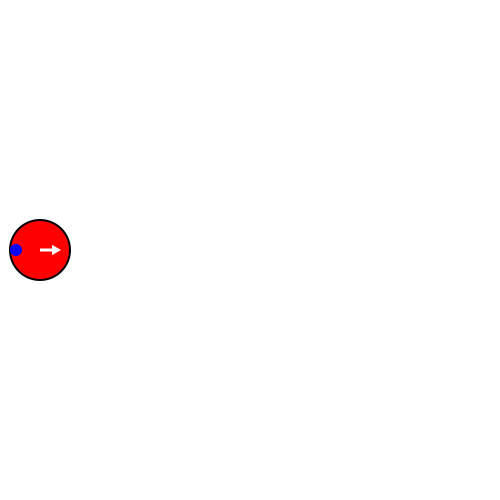

In [39]:
wormy = Organism(x=-210, y=0, radius=30, stem_angle=np.pi)
wormy.set_gradients()
wormy.draw()

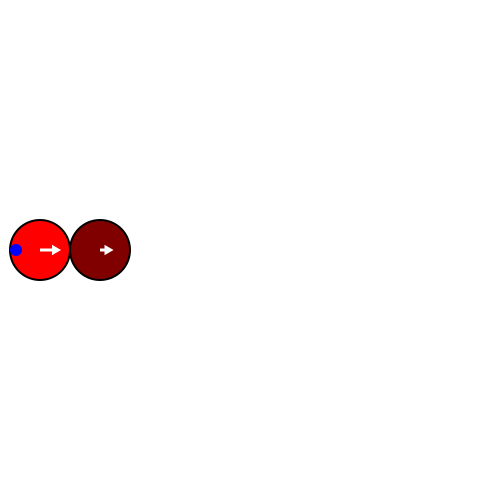

In [40]:
wormy.iterate()
wormy.draw()

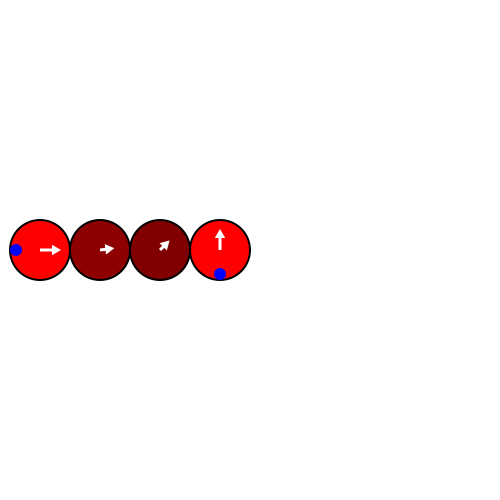

In [41]:
wormy.iterate()
wormy.draw()

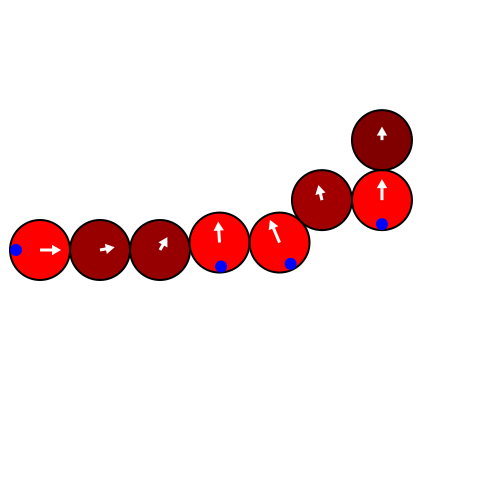

In [42]:
wormy.iterate()
wormy.draw()

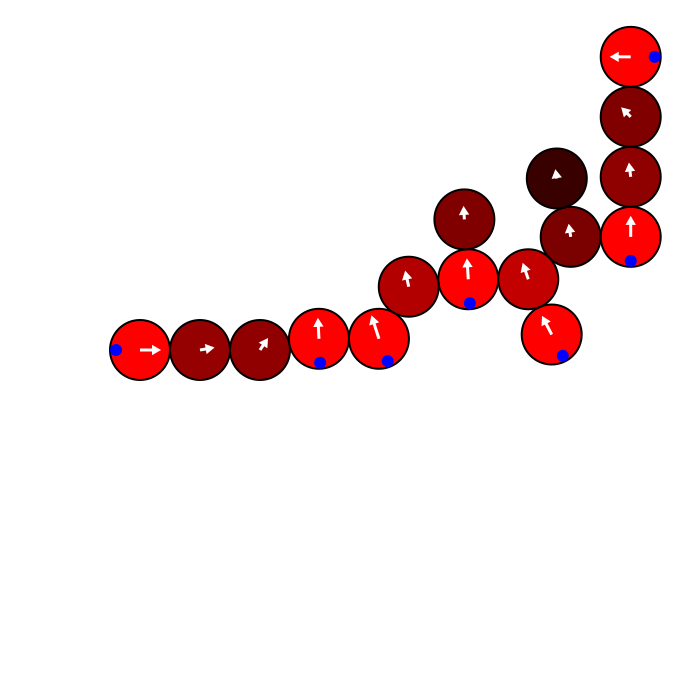

In [43]:
wormy.iterate()
wormy.draw(size=700)

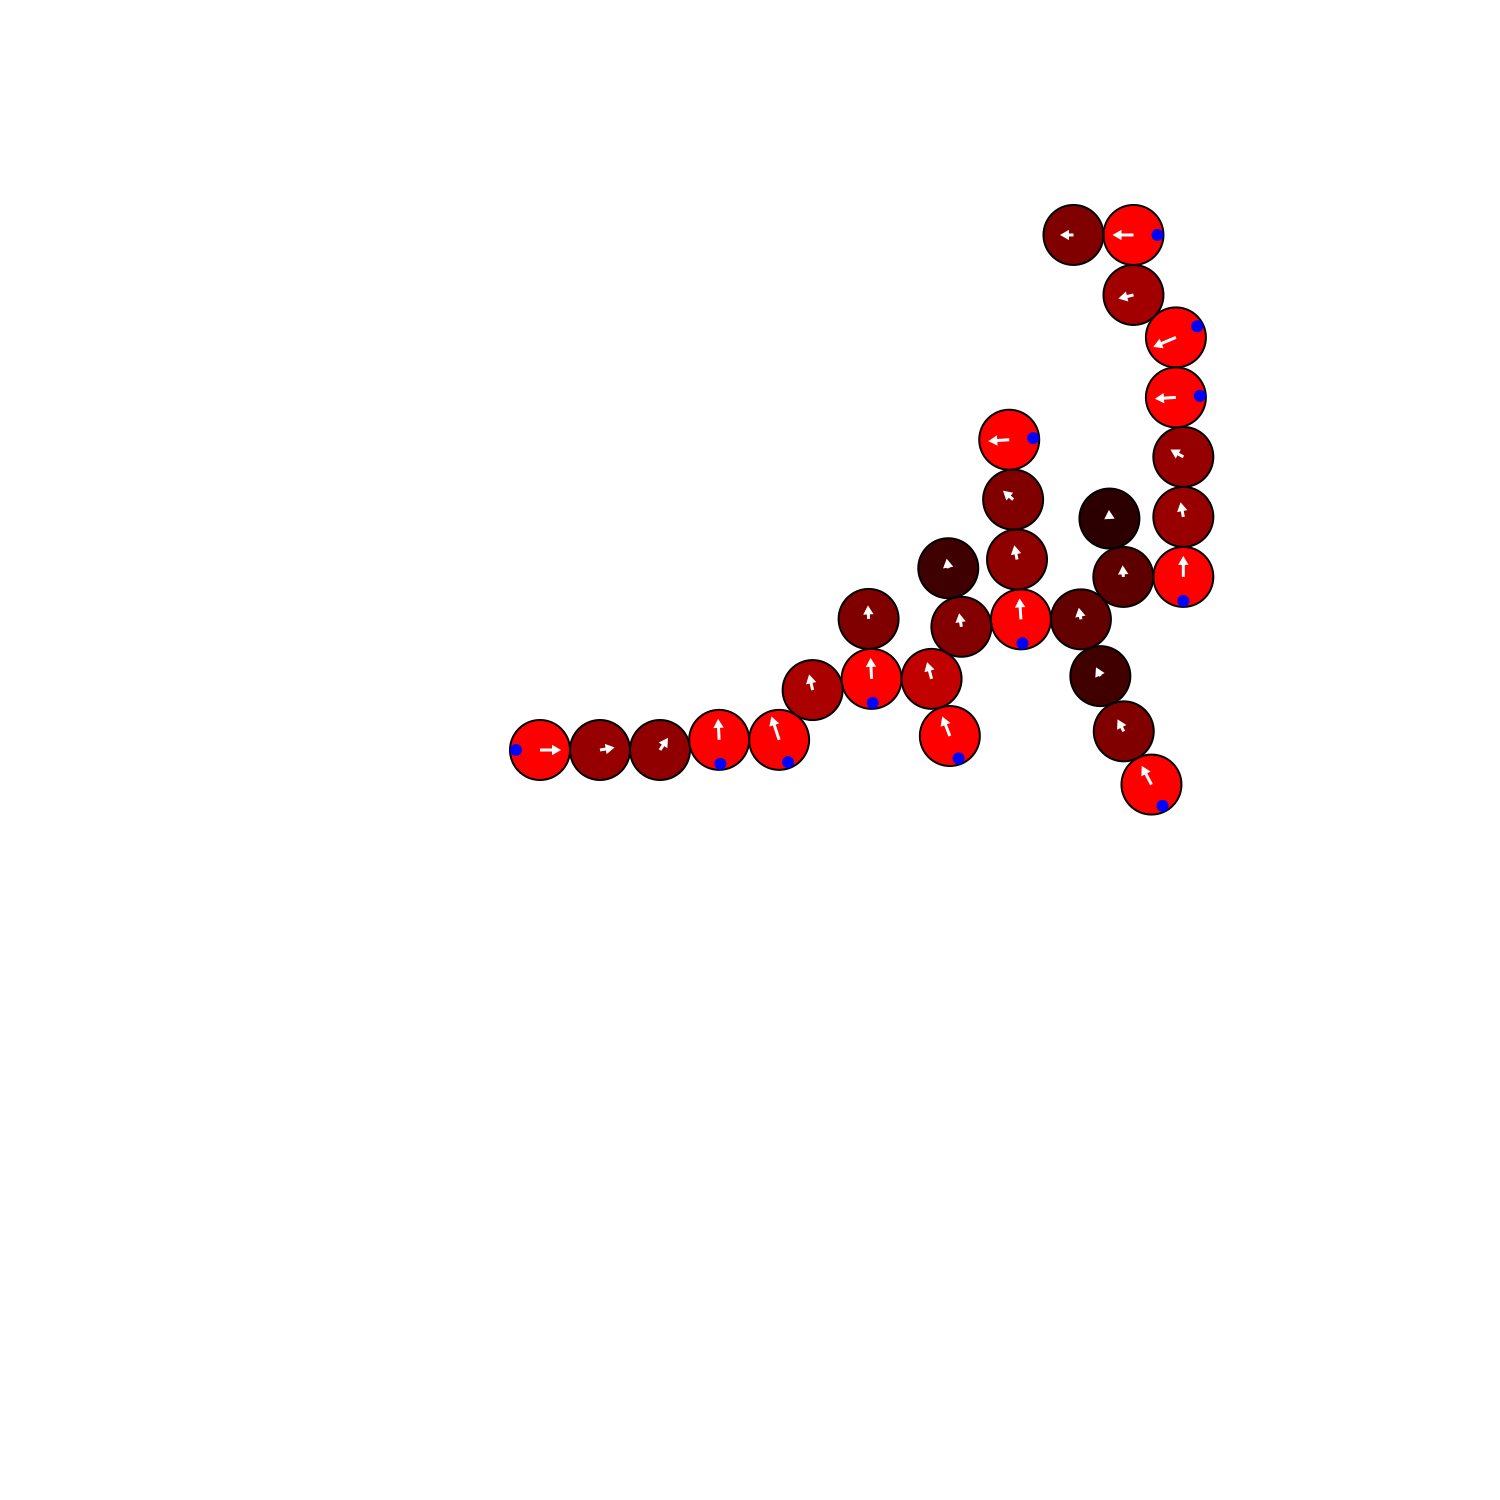

In [44]:
wormy.iterate()
wormy.draw(size=1500)

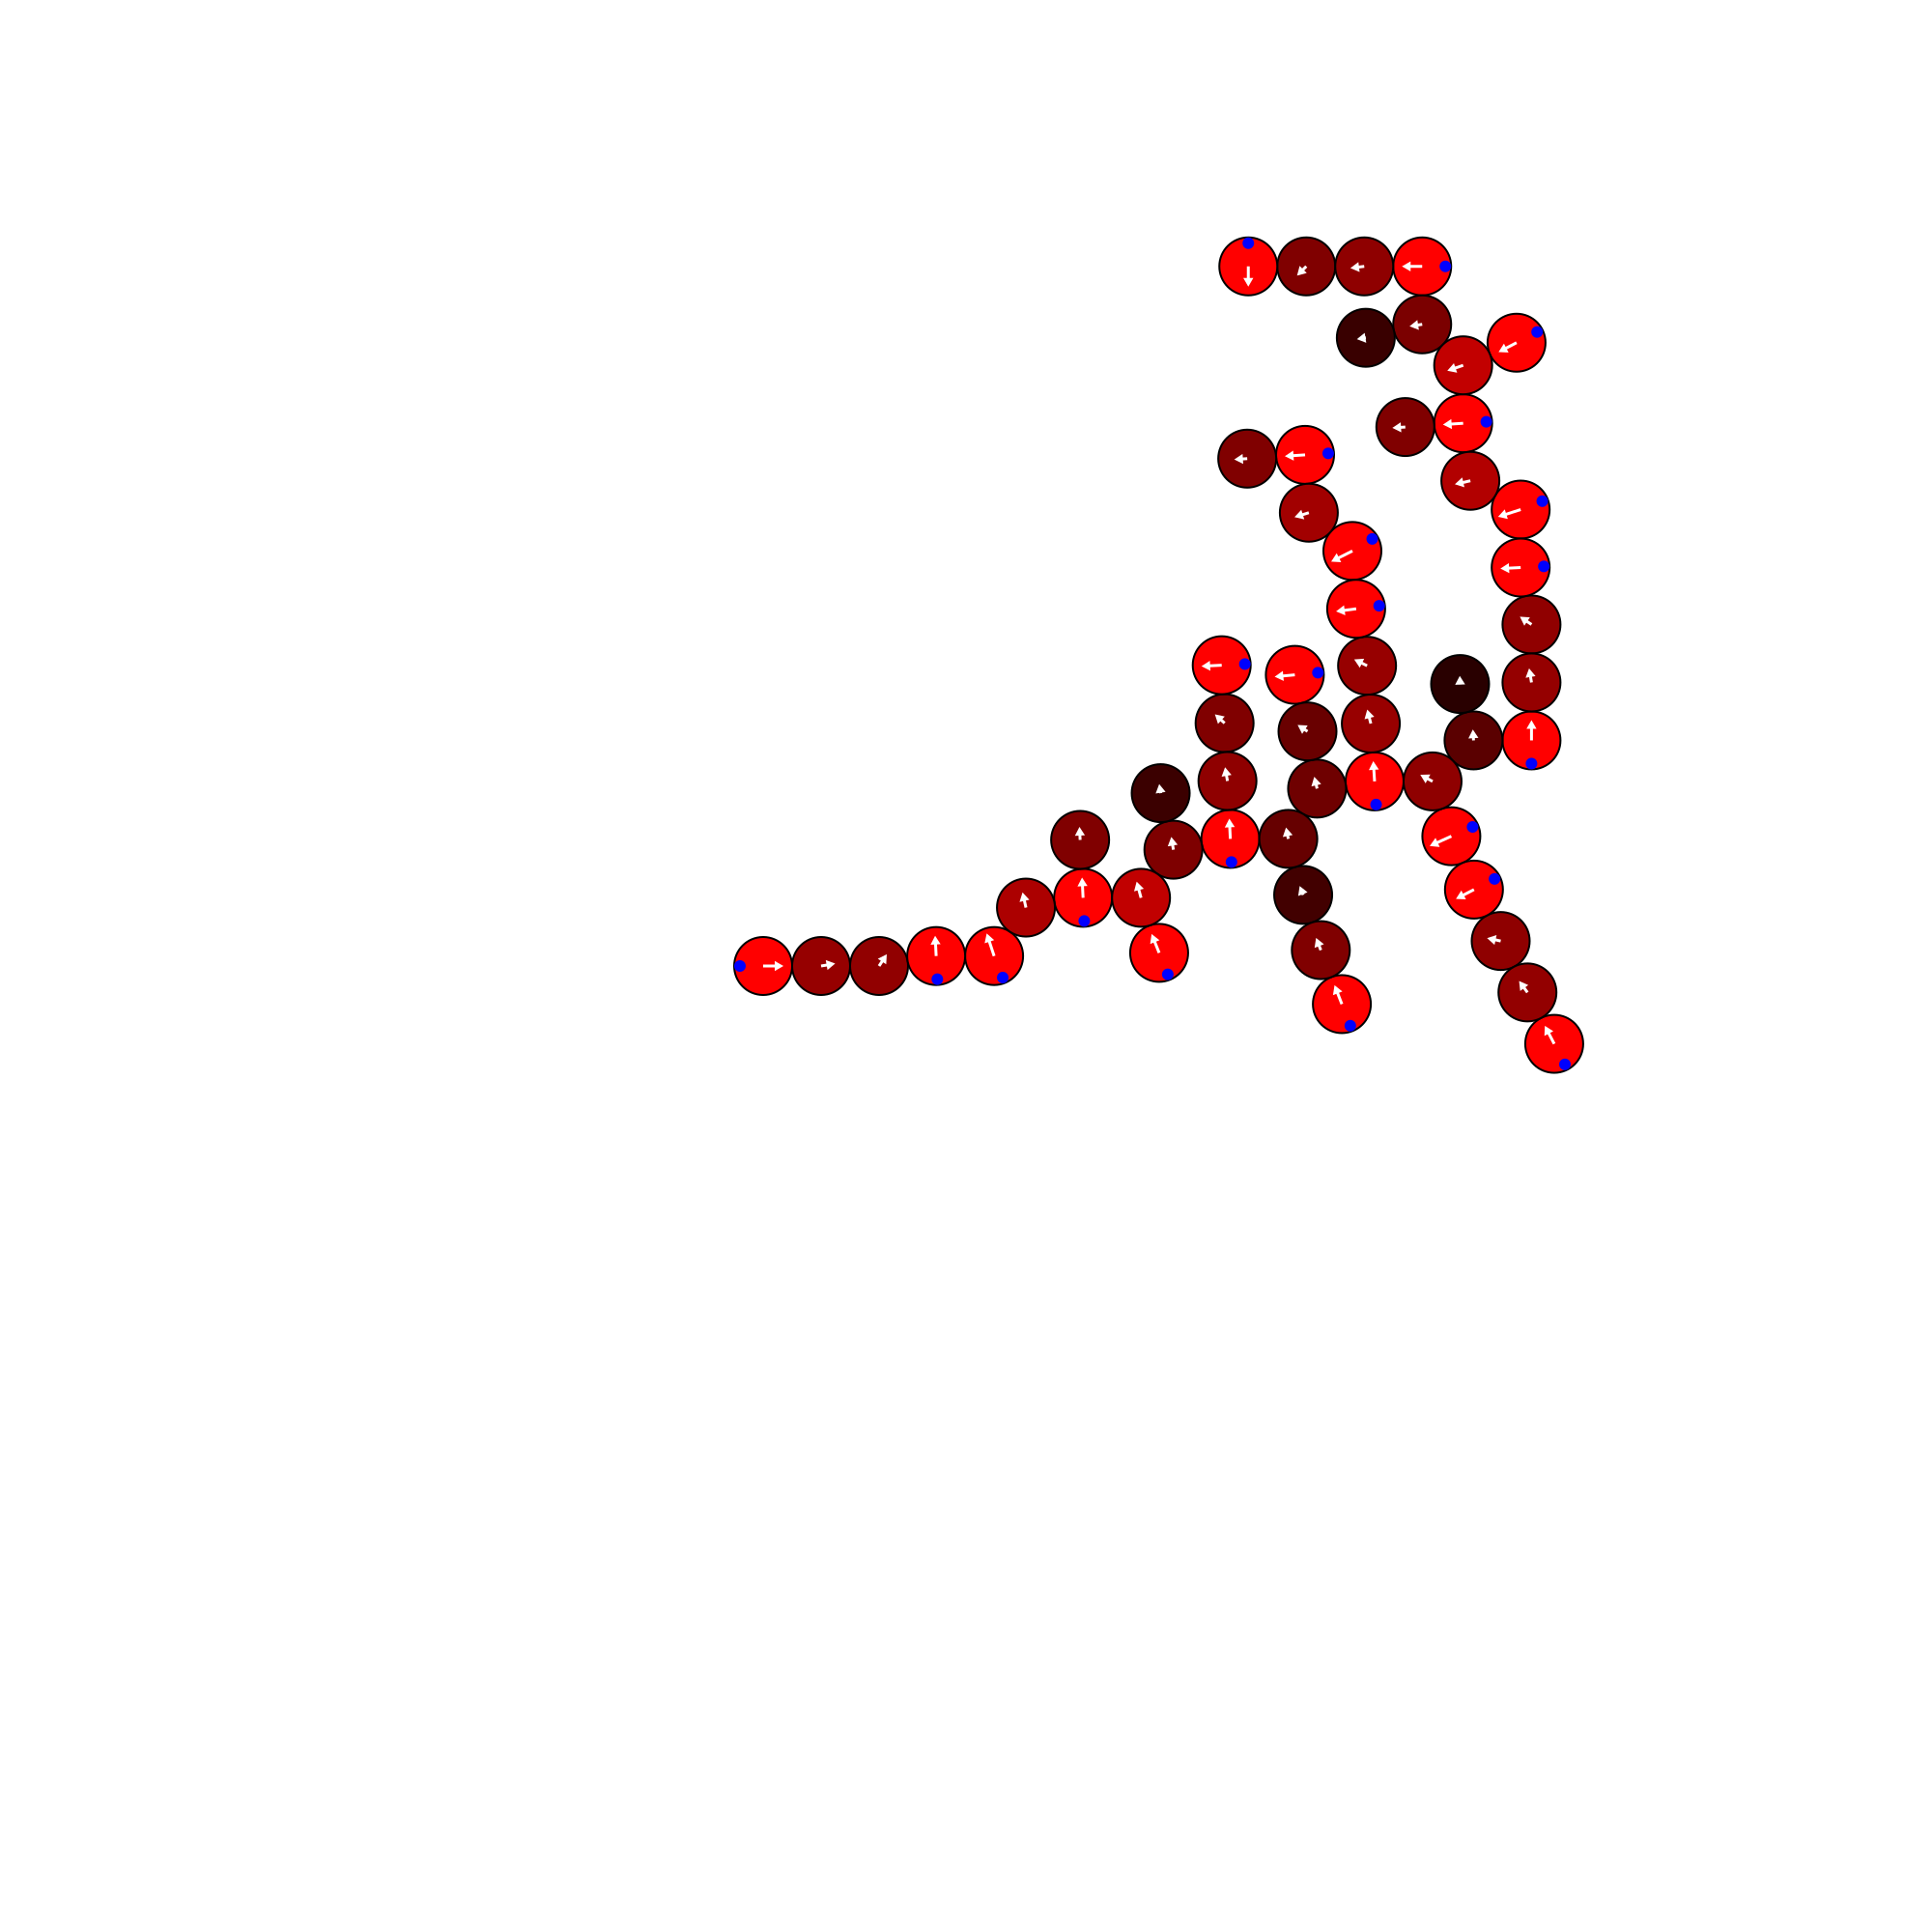

In [45]:
wormy.iterate()
wormy.draw(size=2000)

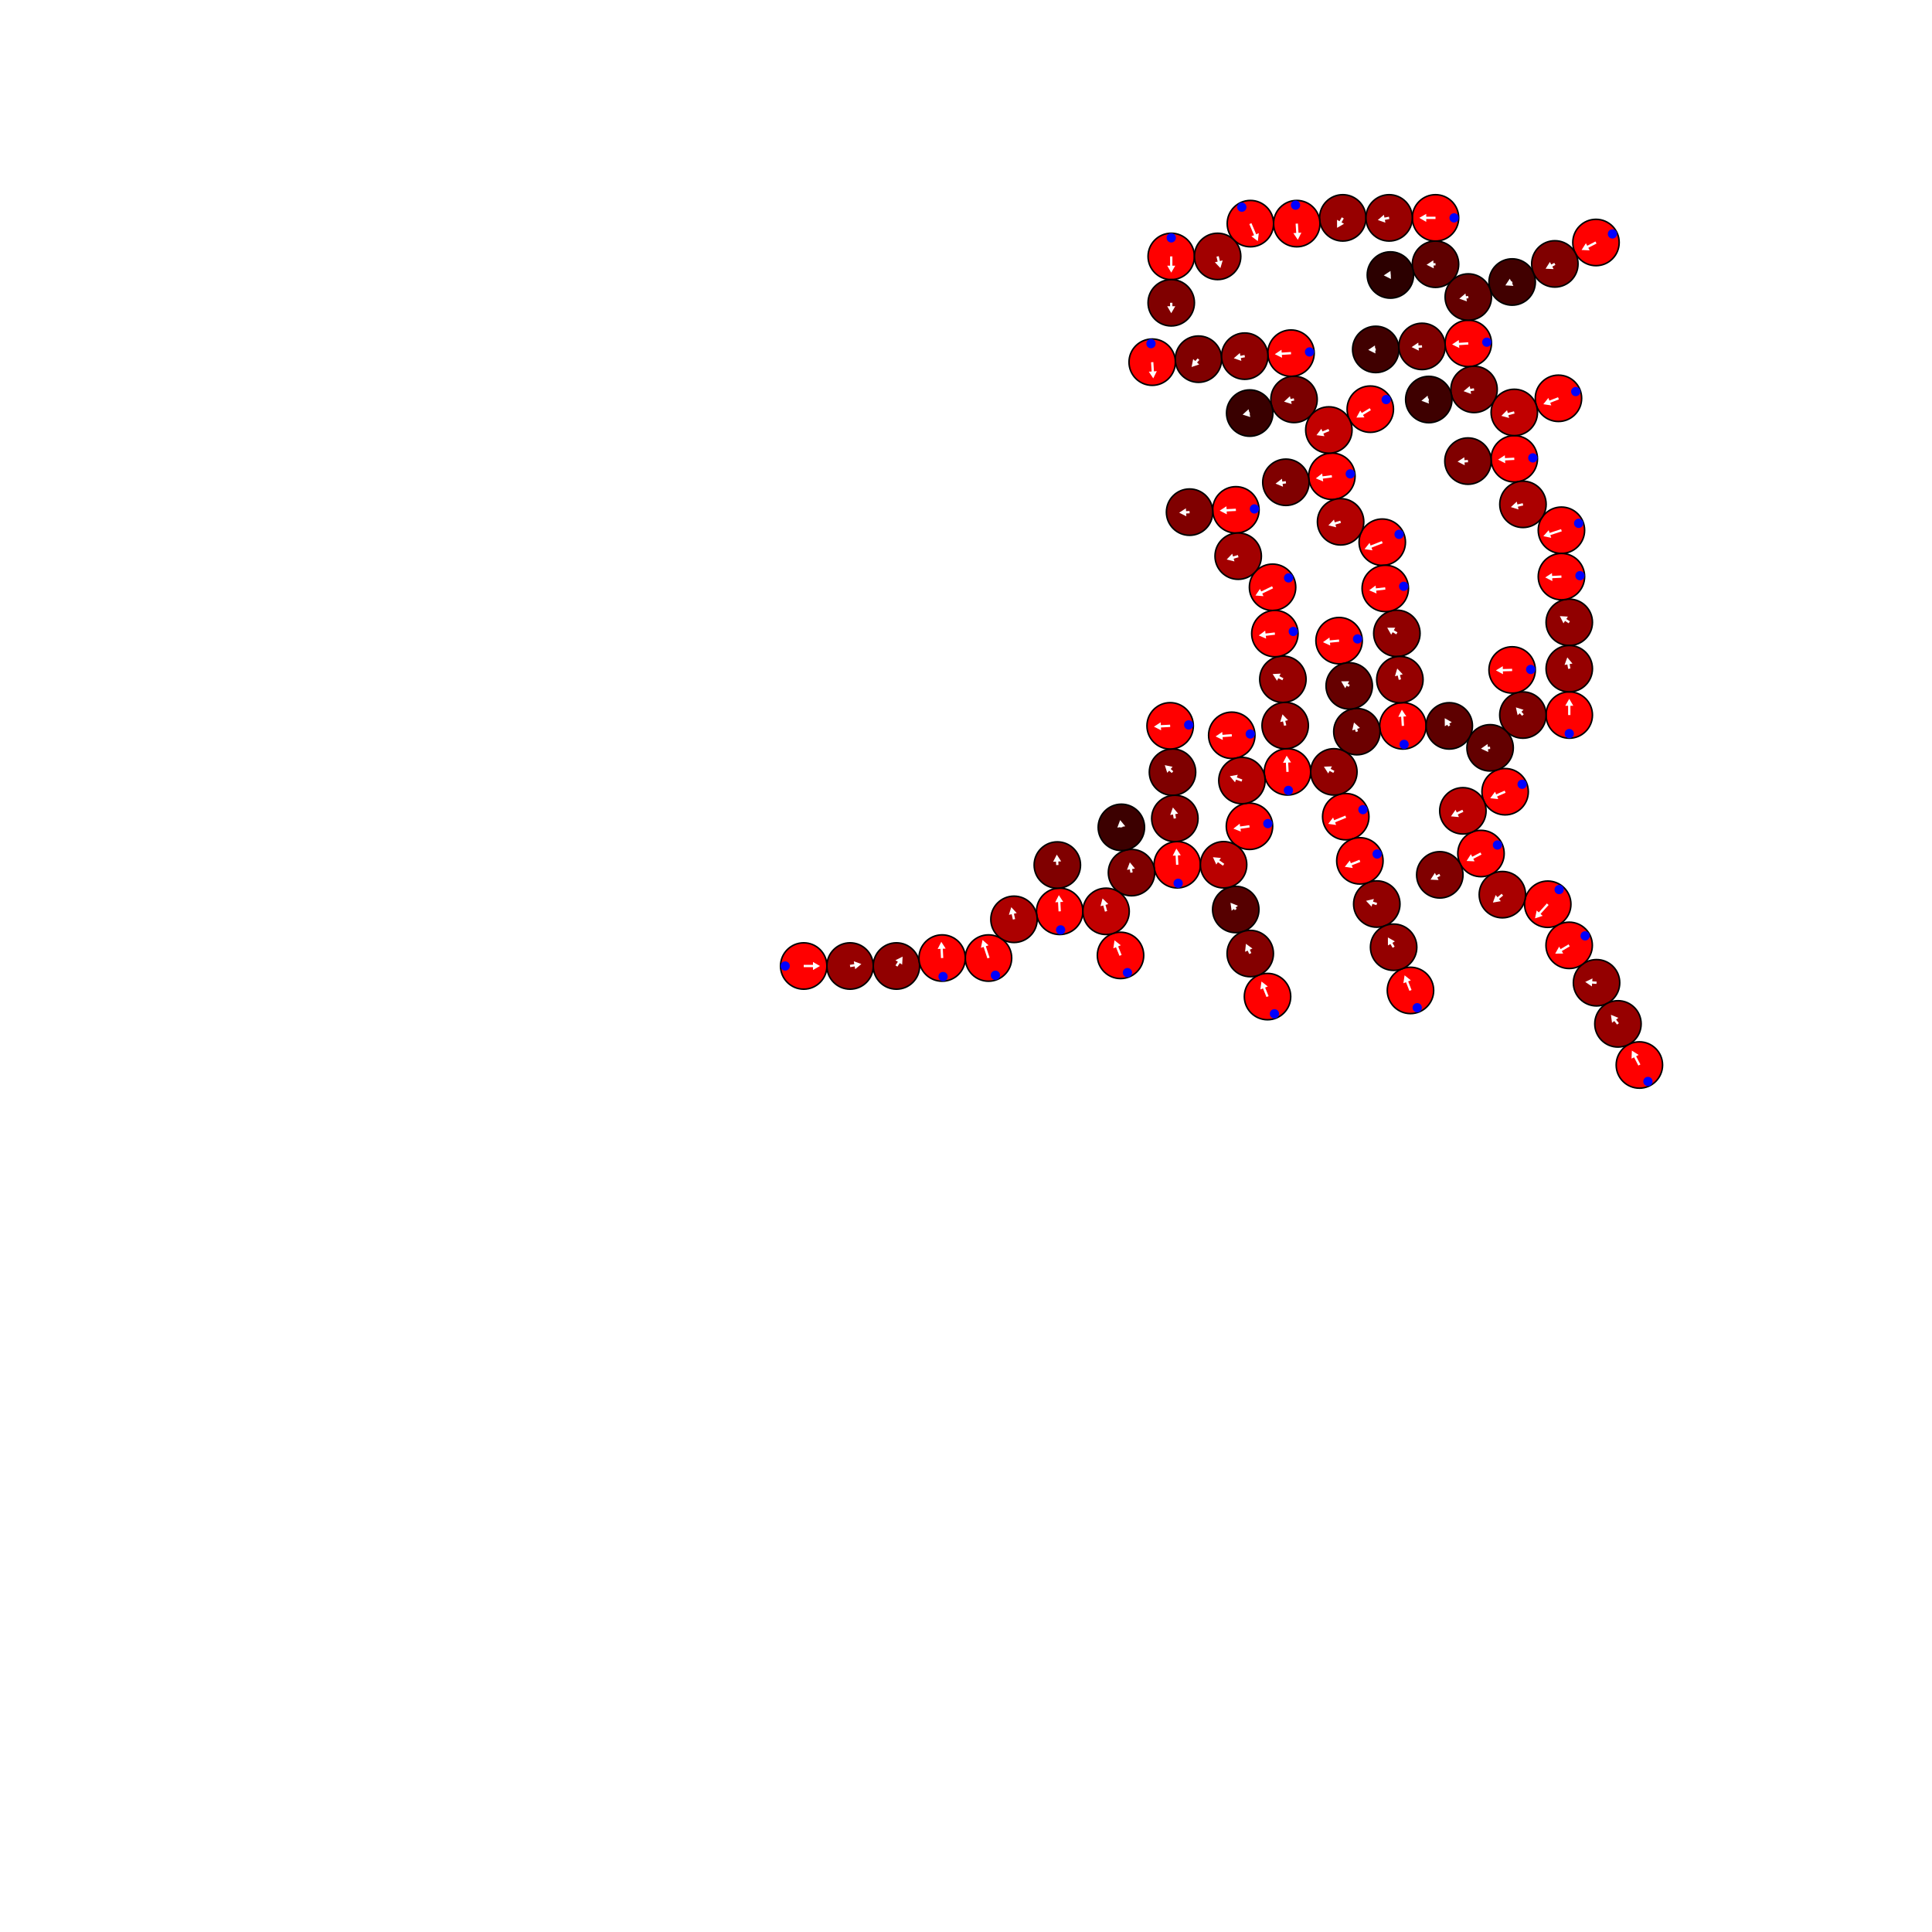

In [46]:
wormy.iterate()
wormy.draw(size=2500)

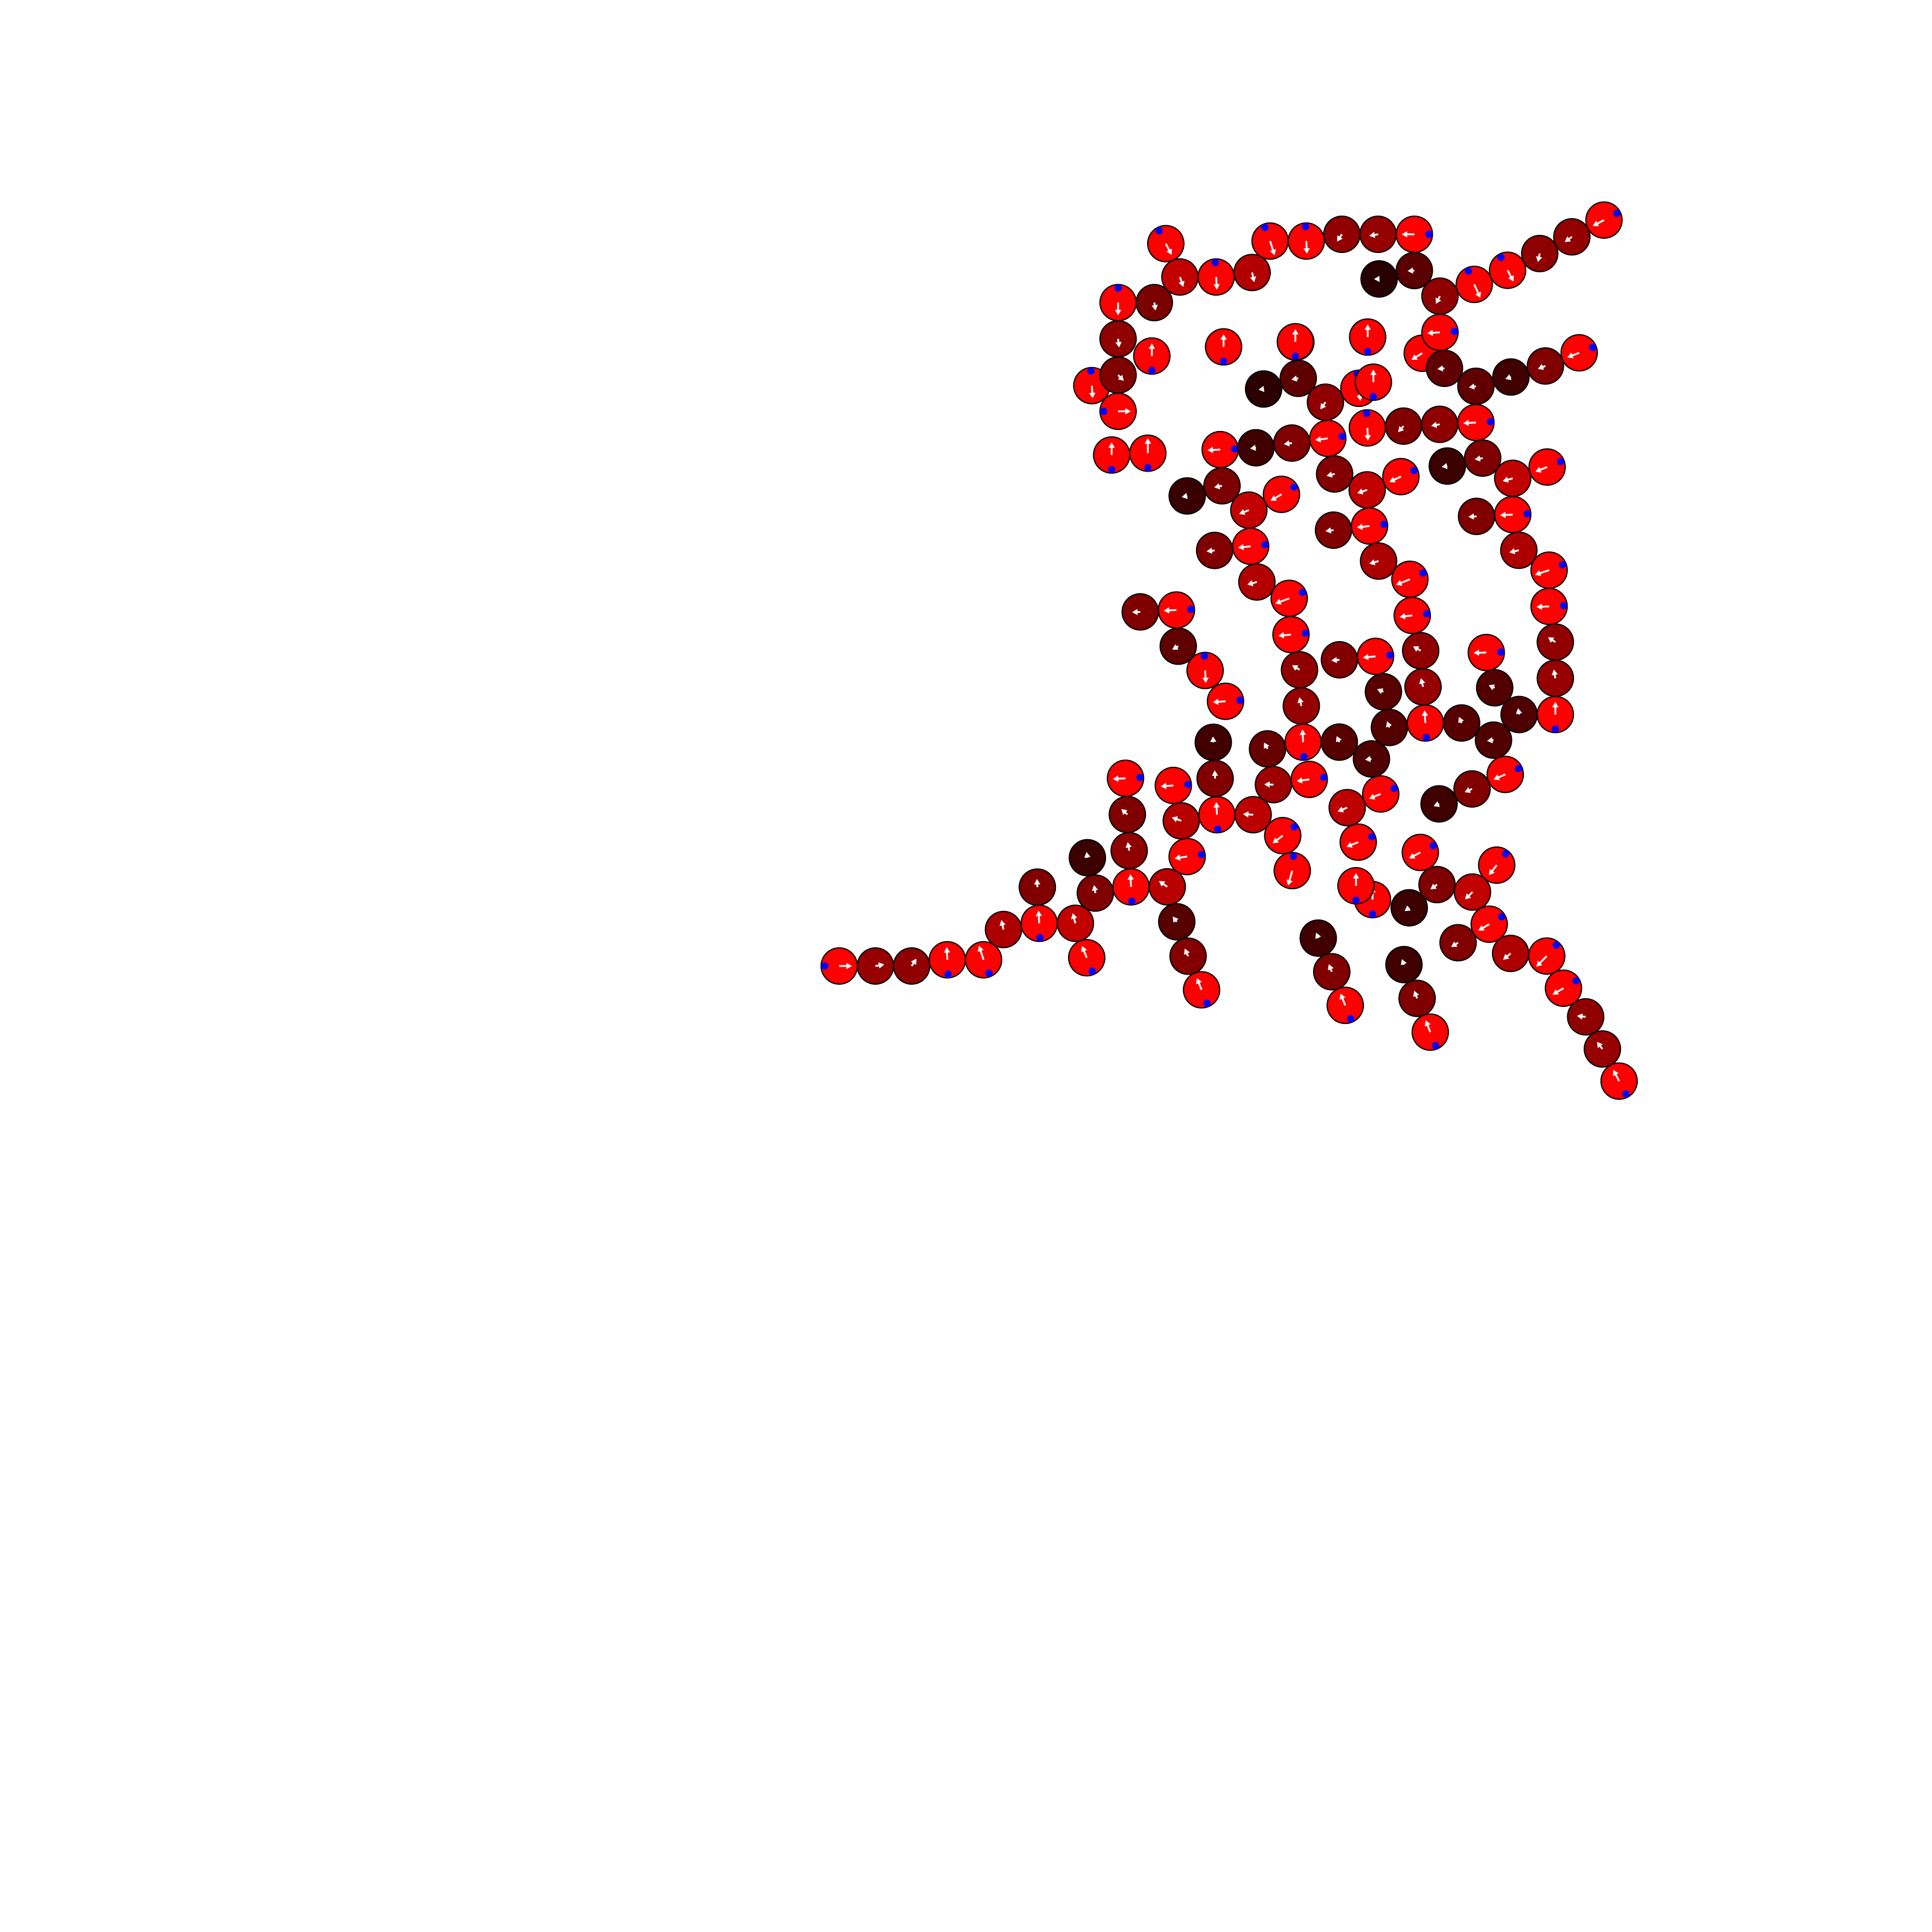

In [47]:
wormy.iterate()
wormy.draw(size=3200)

In [48]:
wormy.print_with_neighbours()

(x: -210, y: 0), 1024 *, gradient: (1024.0, 0.0)
--- (x: -150.0, y: 0.0), 600.9505503002739 , gradient: (498.48, -86.86)
(x: 1081.766040273429, y: 190.66289938494074), 1024 *, gradient: (-472.86, -908.28)
--- (x: 1054.0594329273451, y: 137.44312947403336), 600.2931178875288 , gradient: (-306.85, -402.57)
(x: 768.982427930273, y: 109.50698299967587), 1024 *, gradient: (-371.93, -954.07)
--- (x: 747.189447328384, y: 53.60469327478459), 512.0 , gradient: (-185.97, -477.03)
(x: 976.1455943717618, y: -416.52869648228295), 1024 *, gradient: (-0.0, -1024.0)
--- (x: 916.1455943717618, y: -416.52869648228295), 315.14660794116406 , gradient: (-44.44, -263.8)
--- (x: 976.1455943717618, y: -476.52869648228295), 600.9382275748826 , gradient: (-86.85, -498.48)
(x: 628.1632609348641, y: 65.19323692806076), 1024 *, gradient: (-381.37, -950.33)
--- (x: 605.817079084331, y: 9.50977298495728), 512.0 , gradient: (-190.69, -475.17)
(x: 916.1455943717618, y: -416.52869648228295), 315.14660794116406 , gradie

In [27]:
import os

angles = np.linspace(0, np.pi, 15)
angles

N = 10

for angle in angles:
    name = str(round(angle, 2))
    Organism.NEW_STEM_ANGLE = angle
    
    wormy = Organism(x=-1500, y=0, radius=30, stem_angle=np.pi)
    wormy.set_gradients()
    
    os.makedirs('cells_models/{}'.format(name), exist_ok=True)
    
    for i in range(1, N):
        wormy.draw(size=3200).write_to_png('cells_models/{}/{}.png'.format(name, i))
        wormy.iterate()
    wormy.draw(size=3200).write_to_png('cells_models/{}/{}.png'.format(name, i+1))